In [77]:
import os
from joblib import Parallel, delayed

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       partitioned_averages)

In [78]:
# Number of Qubits 
N=9
# Number of excitations
k=4
# RNG seed for reproducibility
seed=4
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=3
# Maximal number of iterations for classical solver
max_iter=80
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False

np.random.seed(seed)



my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1,0,1,0])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())

 Qubit indices in chain: 
 [0 1 2 3 4 5 6 7 8]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8)]

 Initialization strategy is: 
 [0 1 0 1 0 1 0 1 0]

 Corresponding indices is: 
 [1, 3, 5, 7]


In [79]:
my_grid = Grid(Rows=3,Cols=3)
print(f' Qubit indices in grid: \n', my_grid.get_grid_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_grid.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_grid.get_NNN_indices())
init_strat = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
my_grid.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_grid.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_grid.get_initialization_indices())

 Qubit indices in grid: 
 [[0 1 2]
 [3 4 5]
 [6 7 8]]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 3), (0, 1), (1, 4), (1, 2), (2, 5), (3, 6), (3, 4), (4, 7), (4, 5), (5, 8), (6, 7), (7, 8)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 3), (0, 1), (1, 4), (1, 2), (2, 5), (3, 6), (3, 4), (4, 7), (4, 5), (5, 8), (6, 7), (7, 8), (0, 6), (0, 2), (1, 7), (2, 8), (3, 5), (6, 8)]

 Initialization strategy is: 
 [[0 1 0]
 [1 0 1]
 [0 1 0]]

 Corresponding indices is: 
 [1, 3, 5, 7]


In [80]:
# Deciding between grid and 1d chain topology
my_topology = my_chain

In [81]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

Min. cost portfolio (constrained subspace): 14.141913198726565
Optimal portfolio state (constrained subspace) is: |101100010>


In [82]:

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")


Min. cost QUBO: 14.141913198726542
Min. cost QUBO state is: |101100010>


In [83]:
print("Check that qubo min cost is same as portfolio min cost:")
qubo_min_cost, portfolio_subspace_min_cost

Check that qubo min cost is same as portfolio min cost:


(14.141913198726542, 14.141913198726565)

In [84]:
print("Check that qubo max cost is at least portfolio max cost:")
qubo_max_cost, portfolio_subspace_max_cost

Check that qubo max cost is at least portfolio max cost:


(448.82125635902037, 22.407206320691806)

In [85]:
# Generating instances of ansatz'
statevector_ansatz = CP_QAOA(N_qubits=N,
                             cardinality=k,
                             layers=layers,
                             topology=my_topology,
                             QUBO_matrix=Q,
                             with_next_nearest_neighbors=w_next_nearest_neighbors,
                             with_z_phase=True,
                             backend='state_vector')

N_SAMPLES = 100000
sample_ansatz = CP_QAOA(N_qubits=N,
                        cardinality=k,
                        layers=layers,
                        topology=my_topology,
                        QUBO_matrix=Q,
                        with_next_nearest_neighbors=w_next_nearest_neighbors,
                        with_z_phase=True,
                        backend='sample',
                        N_samples=N_SAMPLES,
                        seed=seed)

In [86]:
# Generating callback function for plotting
CP_statevector_costs = [] # Normalized costs
CP_statevector_probs = [] # probability of optimal state
def CP_statevector_callback_function(x):
    _dict_ = statevector_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=qubo_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_statevector_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_statevector_probs.append(0)
    CP_statevector_costs.append(_cost_)
    
CP_sample_costs = [] # Normalized costs
CP_sample_probs = [] # probability of optimal state
def CP_sample_callback_function(x):
    _dict_ = sample_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=qubo_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_sample_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_sample_probs.append(0)
    CP_sample_costs.append(_cost_)

# Generating initial guess for rotation angles for CP_ansatz
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles += layers * len(my_topology.get_NNN_indices())
N_angles += layers * N # Because this is WITH Z-phase
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

# Performing optimization
CP_statevector_res = sc.optimize.minimize(fun=statevector_ansatz.get_cost, x0=CP_z_phase_theta_i,
                                          method='Powell',
                                          options={'disp': False, 'maxiter': max_iter},
                                          callback=CP_statevector_callback_function)

CP_sample_res = sc.optimize.minimize(fun=sample_ansatz.get_cost, x0=CP_z_phase_theta_i,
                                     method='Powell',
                                     options={'disp': False, 'maxiter': max_iter},
                                     callback=CP_sample_callback_function)


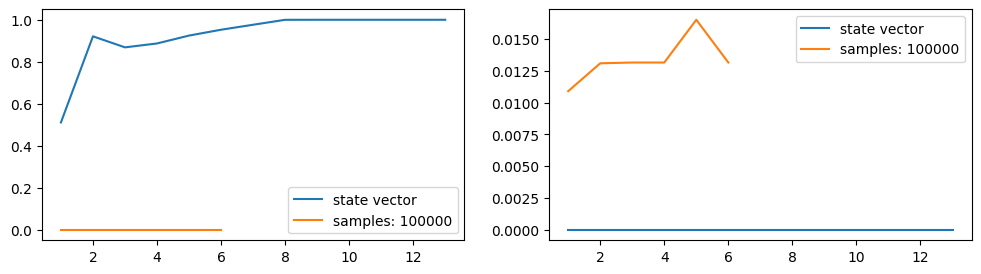

In [87]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
statevector_iterations, sample_iterations = [it+1 for it in range(len(CP_statevector_costs))], [it+1 for it in range(len(CP_sample_costs))]
ax[0].plot(statevector_iterations, CP_statevector_probs, label='state vector')
ax[0].plot(sample_iterations, CP_sample_probs, label=f'samples: {N_SAMPLES}')
ax[0].legend()

ax[1].plot(statevector_iterations, CP_statevector_costs, label='state vector')
ax[1].plot(sample_iterations, CP_sample_costs, label=f'samples: {N_SAMPLES}')
ax[1].legend()


In [88]:
CP_statevector_res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -16.317589962115548
       x: [ 2.053e+00 -4.205e+00 ...  1.862e+00 -3.791e-01]
     nit: 13
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 15567

In [89]:
CP_sample_res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6.667821488694273
       x: [ 3.105e+00 -4.309e+00 ...  2.196e+00  2.262e+00]
     nit: 6
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 5451

In [90]:
CP_sample_costs, CP_sample_probs

([0.010900126914968849,
  0.013092605000036032,
  0.013152437366485647,
  0.013152437366485647,
  0.01651443784116933,
  0.013152437366485647],
 [0, 0, 0, 0, 0, 0])

In [91]:
CP_statevector_costs, CP_statevector_probs

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.511133684760064,
  0.921205605528722,
  0.868618875908304,
  0.887250702237723,
  0.92475161568092,
  0.952647615561454,
  0.976327817751932,
  0.999822292583898,
  0.999981462193879,
  0.999983429655445,
  0.99998411997984,
  0.999985156009501,
  0.999985487734574])